# 📘 Machine Learning 2025/2026  

# Lab9: Gaussian Mixture Models (GMM) e algoritmo EM
### Docenti: Danilo Croce, Giorgio Gambosi  

In questo laboratorio studiamo un approccio probabilistico al clustering
basato su **Gaussian Mixture Models (GMM)** e sull'algoritmo
**Expectation–Maximization (EM)**.

Obiettivi:
- capire la differenza tra clustering *hard* (k-means) e *soft*
- implementare EM per GMM
- interpretare le responsabilità γ
- confrontare GMM con k-means

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

## Dataset

Generiamo un dataset bidimensionale con tre cluster.
Useremo questo dataset per confrontare k-means e GMM.

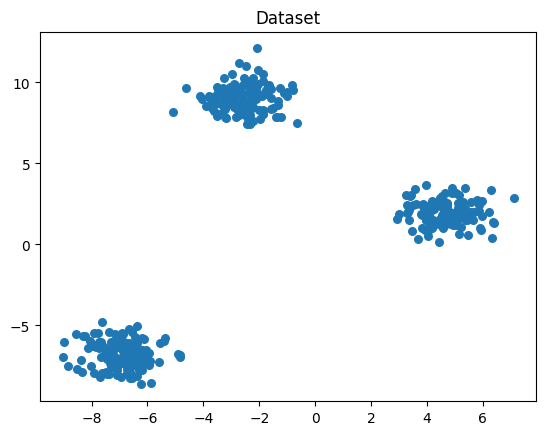

In [ ]:
np.random.seed(42)

X, y_true = make_blobs(
    n_samples=400,
    centers=3,
    cluster_std=0.8,
    random_state=42
)

plt.scatter(X[:,0], X[:,1], s=30)
plt.title("Dataset")
plt.show()

## Clustering con k-means (from scratch)

k-means è un algoritmo di **clustering hard**:
ogni punto viene assegnato **a un solo cluster**.

Dato un numero prefissato di cluster K, l'algoritmo procede iterativamente:

1. **Inizializzazione**  
   Si scelgono K centroidi iniziali (tipicamente in modo casuale).

2. **Assignment step**  
   Ogni punto xᵢ viene assegnato al cluster il cui centroide è più vicino
   secondo la distanza euclidea.

3. **Update step**  
   Ogni centroide viene aggiornato come media dei punti assegnati al cluster.

I passi 2 e 3 vengono ripetuti fino a convergenza.

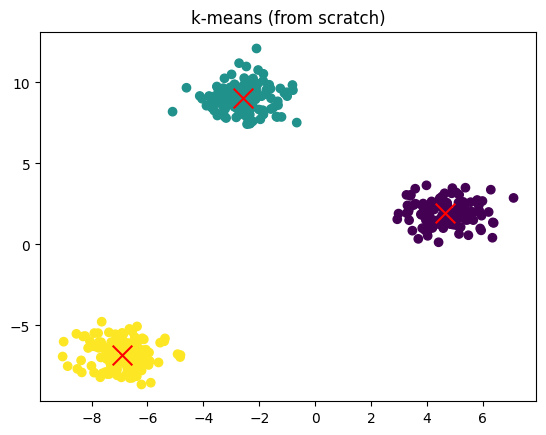

In [ ]:
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, K):
    return np.array([
        X[labels == k].mean(axis=0)
        for k in range(K)
    ])

K = 3
np.random.seed(0)

# inizializzazione casuale dei centroidi
indices = np.random.choice(len(X), K, replace=False)
centroids = X[indices]

for iteration in range(10):
    labels = assign_clusters(X, centroids)
    centroids = update_centroids(X, labels, K)

plt.scatter(X[:,0], X[:,1], c=labels, cmap="viridis")
plt.scatter(centroids[:,0], centroids[:,1],
            c="red", marker="x", s=200)
plt.title("k-means (from scratch)")
plt.show()




## Clustering con k-means (in scikit-learn)

k-means assegna **ogni punto a un solo cluster**.
L'assegnazione è *hard* (vettore 1-hot).

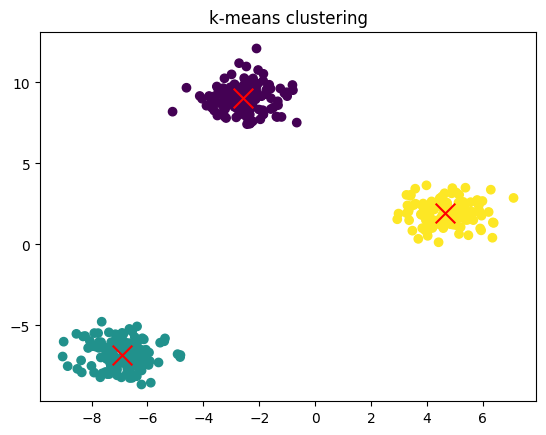

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=labels_kmeans, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            c="red", marker="x", s=200)
plt.title("k-means clustering")
plt.show()

### Osservazione

k-means produce un'assegnazione **deterministica**:
ogni punto appartiene a **un solo cluster**.

Non possiamo:
- rappresentare incertezza
- gestire punti ambigui
- stimare una probabilità p(x)

Questo ci porta al concetto di **soft clustering**.

# Gaussian Mixture Model

In un GMM assumiamo che:
1. ogni punto sia generato da un cluster latente z
2. ogni cluster sia una distribuzione gaussiana
3. ogni punto abbia una **probabilità di appartenere a ciascun cluster**

Useremo l'algoritmo EM per stimare i parametri del modello.

## Inizializzazione dei parametri

L'algoritmo EM richiede una stima iniziale dei parametri
$\pi_k$ e $\theta_k = (\mu_k, \Sigma_k)$.

Questa inizializzazione **non deve essere accurata**:
EM migliora iterativamente i parametri a partire da una stima grezza.

In questo laboratorio usiamo una inizializzazione semplice e neutra.

In [ ]:
K = 3
n, d = X.shape

# medie iniziali: punti scelti casualmente dal dataset
indices = np.random.choice(n, K, replace=False)
mu = X[indices]

# covarianze iniziali: identità
Sigma = [np.eye(d) for _ in range(K)]

# pesi iniziali: uniformi
pi = np.ones(K) / K

**Osservazione**:
l'inizializzazione influenza la convergenza dell'algoritmo,
che può fermarsi in minimi locali.

In applicazioni pratiche si usano inizializzazioni più sofisticate
(ad esempio k-means),
ma qui privilegiamo la semplicità per rendere esplicito
il funzionamento dell'algoritmo EM.

**Nota**: se le covarianze sono tutte identità e i pesi sono uniformi,
il comportamento iniziale del GMM è vicino a quello di k-means.
EM può essere visto come una generalizzazione probabilistica
di k-means.

## E-step

Calcoliamo le **responsabilità**:

γᵢₖ = P(zᵢ = k | xᵢ)

cioè la probabilità che il punto xᵢ sia stato generato
dalla componente k.

La densità di probabilità di una Gaussiana d-dimensionale è:

$$
\mathscr{N}(x \mid \mu, \Sigma)
=
\frac{1}{\sqrt{(2\pi)^d \, |\Sigma|}}
\exp\!\left(
-\frac{1}{2}
(x - \mu)^\top
\Sigma^{-1}
(x - \mu)
\right)
$$

dove:
- $x \in \mathbb{R}^d$ è il punto osservato
- $\mu \in \mathbb{R}^d$ è il vettore delle medie
- $\Sigma \in \mathbb{R}^{d \times d}$ è la matrice di covarianza
- $|\Sigma|$ è il determinante di \(\Sigma\)

In [ ]:
def gaussian_pdf(x, mu, Sigma):
    d = len(mu)
    diff = x - mu
    inv = np.linalg.inv(Sigma)
    det = np.linalg.det(Sigma)
    norm = 1 / np.sqrt((2*np.pi)**d * det)
    return norm * np.exp(-0.5 * diff @ inv @ diff)

## E-step: calcolo delle responsabilità γ

Come visto nelle slide sulla **stima dei parametri di una mixture**
(slide 18–19), l’ottimizzazione diretta della log-likelihood

$$
\ell(\pi, \theta \mid X)
=
\sum_{i=1}^n
\log \sum_{k=1}^K \pi_k \, q(x_i \mid \theta_k)
$$

non è trattabile in forma chiusa.

L’idea chiave dell’algoritmo **Expectation–Maximization (EM)**
è introdurre le **variabili latenti** $z_i$,
che indicano quale componente della mixture ha generato il punto $x_i$.

Nel passo di **Expectation (E-step)** calcoliamo, per ogni punto $x_i$,
la probabilità a posteriori che sia stato generato dal cluster $k$:

$$
\gamma_k(x_i)
=
P(z_i = k \mid x_i, \pi, \theta)
=
\frac{
\pi_k \, q(x_i \mid \theta_k)
}{
\sum_{j=1}^K \pi_j \, q(x_i \mid \theta_j)
}
$$

Queste quantità sono dette **responsabilità**:
misurano quanto ciascuna componente della mixture
“spiega” il punto osservato $x_i$.

Nel nostro caso $q(x \mid \theta_k)$ è una **Gaussiana multivariata**
con parametri $\theta_k = (\mu_k, \Sigma_k)$.

Il codice seguente implementa esattamente la formula precedente:
- il numeratore calcola $\pi_k \, \mathscr{N}(x_i \mid \mu_k, \Sigma_k)$
- la normalizzazione garantisce che
  $\sum_k \gamma_k(x_i) = 1$

Ogni riga della matrice γ è quindi una distribuzione di probabilità sui cluster.

In [ ]:
def e_step(X, pi, mu, Sigma):
    n, K = X.shape[0], len(pi)
    gamma = np.zeros((n, K))

    for i in range(n):
        for k in range(K):
            gamma[i,k] = pi[k] * gaussian_pdf(X[i], mu[k], Sigma[k])
        gamma[i] /= np.sum(gamma[i])
    return gamma

Ogni riga di γ è un **vettore di probabilità**:

- γᵢₖ ≥ 0
- ∑ₖ γᵢₖ = 1

Non otteniamo un'etichetta secca,
ma una **soft assignment**.



## M-step: aggiornamento dei parametri

Nel passo di **Maximization (M-step)** aggiorniamo i parametri del modello
assumendo che le responsabilità γ calcolate nell’E-step siano fissate.

Intuitivamente:
- ogni punto contribuisce a ciascun cluster **in modo proporzionale**
  alla sua responsabilità
- i parametri di ogni componente vengono stimati
  come **medie pesate** sui dati

In questo modo la M-step massimizza
l’**expected complete-data log-likelihood**.


Le responsabilità γᵢₖ possono essere interpretate come
un **conteggio frazionario**:
anziché assegnare un punto a un solo cluster,
ogni punto contribuisce parzialmente a tutti i cluster.

Questo è l’analogo probabilistico dell’update step di k-means.

In particolare:

- **Pesi della mixture**
$$
\pi_k = \frac{1}{n} \sum_{i=1}^n \gamma_{ik}
$$
rappresentano la frazione di punti spiegata dalla componente k.

- **Medie**
$$
\mu_k = \frac{1}{N_k} \sum_{i=1}^n \gamma_{ik} \, x_i
$$
sono medie pesate dei dati.

- **Covarianze**
$$
\Sigma_k =
\frac{1}{N_k}
\sum_{i=1}^n
\gamma_{ik}
(x_i - \mu_k)(x_i - \mu_k)^\top
$$
modellano forma e orientamento del cluster.

In [ ]:
def m_step(X, gamma):
    n, d = X.shape
    K = gamma.shape[1]

    Nk = np.sum(gamma, axis=0)
    pi_new = Nk / n

    mu_new = np.zeros((K, d))
    Sigma_new = []

    for k in range(K):
        mu_new[k] = np.sum(gamma[:,k,None] * X, axis=0) / Nk[k]
        diff = X - mu_new[k]
        cov = np.zeros((d,d))
        for i in range(n):
            cov += gamma[i,k] * np.outer(diff[i], diff[i])
        Sigma_new.append(cov / Nk[k])

    return pi_new, mu_new, Sigma_new

## Algoritmo EM

Alterniamo E-step e M-step fino a convergenza.

In questo laboratorio fissiamo un numero massimo di iterazioni.
In applicazioni reali, EM viene fermato quando la log-likelihood converge.

In [ ]:
for iteration in range(50):
    gamma = e_step(X, pi, mu, Sigma)
    pi, mu, Sigma = m_step(X, gamma)

## Ricalcolo delle responsabilità γ per singoli punti

Le responsabilità γ **non sono dati osservati** né parametri del modello.
Sono quantità *derivate*, calcolate a partire dai parametri correnti del GMM
utilizzando la formula di Bayes.

Dato un punto $x$, le responsabilità sono definite come:

$$
\gamma_k(x)
=
P(z = k \mid x, \pi, \theta)
=
\frac{
\pi_k \, \mathscr{N}(x \mid \mu_k, \Sigma_k)
}{
\sum_{j=1}^K \pi_j \, \mathscr{N}(x \mid \mu_j, \Sigma_j)
}
$$

Questa formula è valida:
- per punti del dataset di training
- per nuovi punti mai osservati

In altre parole, dato un modello GMM stimato,
possiamo sempre ricalcolare le responsabilità di qualsiasi punto.

In [ ]:
def compute_gamma_for_point(x, pi, mu, Sigma):
    """
    Calcola le responsabilità γ_k(x) per un singolo punto x
    a partire dai parametri correnti del GMM.
    """
    K = len(pi)
    gamma_x = np.zeros(K)

    for k in range(K):
        gamma_x[k] = pi[k] * gaussian_pdf(x, mu[k], Sigma[k])

    gamma_x /= np.sum(gamma_x)
    return gamma_x

In [ ]:
np.random.seed(1)
indices = np.random.choice(n, size=5, replace=False)

print("Responsabilità ricalcolate per alcuni punti:\n")

for i in indices:
    gamma_x = compute_gamma_for_point(X[i], pi, mu, Sigma)
    print(f"Punto x_{i} = {X[i]}")
    for k in range(K):
        print(f"  γ_{k}(x_{i}) = {gamma_x[k]:.4f}")
    print(f"  somma = {gamma_x.sum():.4f}")
    print("-" * 40)

Responsabilità ricalcolate per alcuni punti:

Punto x_398 = [-1.20326858  7.87017303]
  γ_0(x_398) = 0.0000
  γ_1(x_398) = 1.0000
  γ_2(x_398) = 0.0000
  somma = 1.0000
----------------------------------------
Punto x_125 = [4.587015   1.00435672]
  γ_0(x_125) = 0.0000
  γ_1(x_125) = 0.0000
  γ_2(x_125) = 1.0000
  somma = 1.0000
----------------------------------------
Punto x_328 = [3.97668283 1.52502485]
  γ_0(x_328) = 0.0000
  γ_1(x_328) = 0.0000
  γ_2(x_328) = 1.0000
  somma = 1.0000
----------------------------------------
Punto x_339 = [-7.36884143 -8.00543847]
  γ_0(x_339) = 1.0000
  γ_1(x_339) = 0.0000
  γ_2(x_339) = 0.0000
  somma = 1.0000
----------------------------------------
Punto x_172 = [4.70177348 1.28414232]
  γ_0(x_172) = 0.0000
  γ_1(x_172) = 0.0000
  γ_2(x_172) = 1.0000
  somma = 1.0000
----------------------------------------


**Valori molto vicini a 0 o 1 indicano alta confidenza del modello,
ma non corrispondono a una decisione hard: la natura del modello resta probabilistica.**

In [ ]:
x_new = np.array([-2.0, 2.0])
print(compute_gamma_for_point(x_new, pi, mu, Sigma))

[3.56807283e-23 4.34659034e-02 9.56534097e-01]


Un GMM può essere usato anche per anomaly detection: punti con bassa p(x) sono outlier.

## Interpretazione delle responsabilità

Il risultato principale dell’algoritmo EM
non è un’assegnazione secca ai cluster,
ma la matrice delle responsabilità γ.

Ogni punto è associato a **una distribuzione di probabilità sui cluster**,
che descrive il grado di compatibilità del punto
con ciascuna componente della mixture.

Visualizziamo nuovamente le responsabilità,
una componente alla volta.

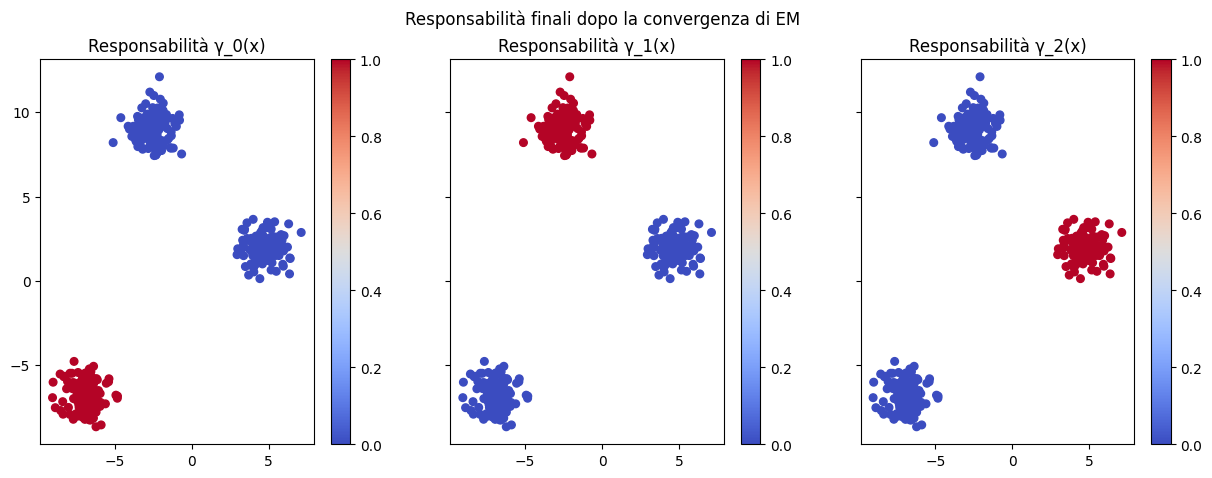

In [ ]:
fig, axes = plt.subplots(1, K, figsize=(15,5), sharex=True, sharey=True)

for k in range(K):
    sc = axes[k].scatter(
        X[:,0], X[:,1],
        c=gamma[:,k],
        cmap="coolwarm",
        vmin=0, vmax=1,
        s=30
    )
    axes[k].set_title(f"Responsabilità γ_{k}(x)")
    fig.colorbar(sc, ax=axes[k])

plt.suptitle("Responsabilità finali dopo la convergenza di EM")
plt.show()

**Nota**:
una inizializzazione basata su k-means
riduce la probabilità che più componenti
collassino sulla stessa regione.

## Visualizzazione delle distribuzioni gaussiane apprese

Dopo la convergenza dell’algoritmo EM, il Gaussian Mixture Model
fornisce una stima completa dei parametri delle componenti:

- il peso della componente πₖ
- la media μₖ
- la matrice di covarianza Σₖ

A questo punto non stiamo più osservando solo
un’assegnazione dei punti ai cluster,
ma **un modello probabilistico dello spazio dei dati**.

In due dimensioni, una distribuzione gaussiana
può essere rappresentata geometricamente tramite
**ellissi di confidenza**.

Le ellissi descrivono:
- la posizione del cluster (μₖ)
- la sua estensione
- il suo orientamento nello spazio

In particolare, i punti all’interno di un’ellisse
corrispondono a regioni di alta probabilità
secondo la distribuzione stimata.


È importante notare che le regioni individuate dalle ellissi
sono direttamente collegate alle responsabilità γ:

un punto ha alta responsabilità per un cluster
se cade in una regione in cui la densità gaussiana
di quella componente è elevata.

Le ellissi non rappresentano “confini” rigidi tra cluster,
ma **regioni di compatibilità probabilistica**.

Questo distingue profondamente i Gaussian Mixture Models
da metodi di clustering basati su assegnazioni hard,
come k-means.

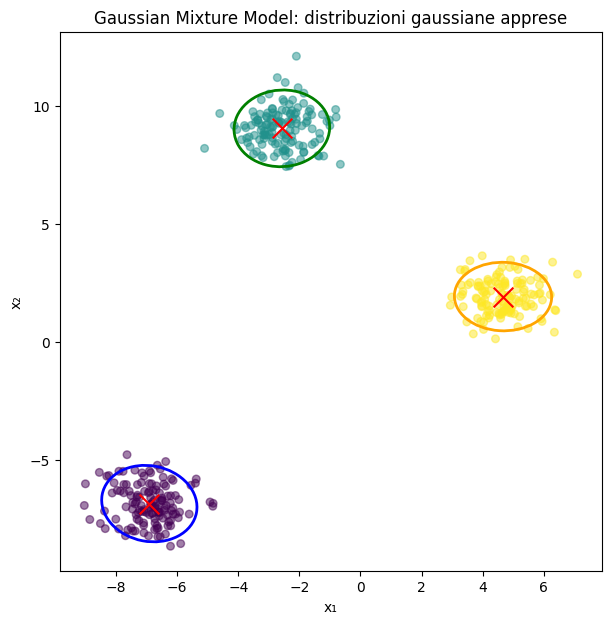

In [ ]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt

def draw_gaussian_ellipse(mu, Sigma, ax, n_std=2, **kwargs):
    """
    Disegna un'ellisse di confidenza per una gaussiana 2D.

    - mu: media (2,)
    - Sigma: covarianza (2x2)
    - n_std: numero di deviazioni standard (default: 2)
    """
    # autovalori e autovettori della covarianza
    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # angolo dell'ellisse
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))

    # dimensioni dell'ellisse
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(
        xy=mu,
        width=width,
        height=height,
        angle=angle,
        fill=False,
        **kwargs
    )
    ax.add_patch(ellipse)


# visualizzazione delle gaussiane apprese
fig, ax = plt.subplots(figsize=(7,7))

# punti (colorati con hard assignment solo per orientamento visivo)
labels_gmm = np.argmax(gamma, axis=1)
ax.scatter(X[:,0], X[:,1], c=labels_gmm, cmap="viridis", s=30, alpha=0.5)

# centri delle gaussiane
ax.scatter(mu[:,0], mu[:,1], c="red", marker="x", s=200, label="Medie μₖ")

colors = ["blue", "green", "orange"]

# ellissi di confidenza
for k in range(K):
    draw_gaussian_ellipse(
        mu[k],
        Sigma[k],
        ax,
        n_std=2,
        edgecolor=colors[k],
        linewidth=2,
        label=f"Cluster {k}" if k == 0 else None
    )

ax.set_title("Gaussian Mixture Model: distribuzioni gaussiane apprese")
ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
plt.show()

## Valutazione dei risultati di clustering

Una domanda naturale, a questo punto, è:

**come valutiamo la qualità di un clustering?**

A differenza del supervised learning, nel clustering **non esiste in generale una “verità a terra”**.
Per questo motivo, la valutazione può essere affrontata da prospettive diverse.

In questa sezione consideriamo il caso in cui
siano disponibili **etichette di riferimento** (classi vere),
ad esempio in dataset artificiali o benchmark.

### Valutazione esterna (con etichette di riferimento)

Quando disponiamo di etichette vere $c_i$,
possiamo confrontare il clustering ottenuto
con la partizione di riferimento.

In questo caso si utilizzano **misure di valutazione esterne**,
che confrontano:

- le **classi vere** $c_i$
- i **cluster stimati** (variabili latenti) $z_i$

### Purity

La **purity** misura quanto ciascun cluster sia “puro”
rispetto alle classi vere.

Per ogni cluster $k$, si considera la probabilità
che un punto appartenente a quel cluster
appartenga alla classe più frequente:

$$
\text{purity}(k)
=
\max_j \; P(c_j \mid z = k)
$$

La purity complessiva è una media pesata sulle dimensioni dei cluster:

$$
\text{purity}
=
\sum_{k=1}^K
\frac{|\mathscr{D}_k|}{|\mathscr{D}|}
\;\text{purity}(k)
$$

dove $\mathscr{D}_k$ è l’insieme dei punti assegnati al cluster $k$.

#### Come si calcola $P(c_j \mid z = k)$?

Nel caso di **hard clustering** (ad esempio k-means),
ogni punto è assegnato a un solo cluster.

In questo caso:

$$
P(c_j \mid z = k)
=
\frac{
\#\{\text{punti di classe } c_j \text{ assegnati al cluster } k\}
}{
\#\{\text{punti assegnati al cluster } k\}
}
$$

cioè una semplice **frequenza empirica**.

**Esempio**

Supponiamo che nel cluster $k$ ci siano 10 punti:
- 7 della classe A
- 3 della classe B

Allora:
- $P(A \mid z = k) = 0.7$
- $P(B \mid z = k) = 0.3$

La purity del cluster è:
$$
\text{purity}(k) = \max\{0.7, 0.3\} = 0.7
$$

**Osservazione importante**

La purity:
- assume implicitamente un **hard clustering**
- **non penalizza** l’uso di molti cluster
- può risultare elevata anche per soluzioni poco informative

Per questo motivo, non è sufficiente da sola
per valutare la qualità di un clustering.


### Mutual Information (MI) e Normalized Mutual Information (NMI)

Un’alternativa più robusta è basata sulla **teoria dell’informazione**.

La **Mutual Information (MI)** misura quanta informazione
la partizione in cluster $Z$
fornisce sulle classi vere $C$:

$$
MI(C, Z)
=
\sum_{c \in C}
\sum_{k=1}^K
P(c, z=k)
\log
\frac{P(c, z=k)}{P(c)\,P(z=k)}
$$

Poiché la MI non è normalizzata,
si usa spesso la **Normalized Mutual Information (NMI)**:

$$
\text{NMI}(C, Z)
=
\frac{MI(C, Z)}{\sqrt{H(C)\,H(Z)}}
$$

**Proprietà della NMI**:
- valori compresi tra 0 e 1
- 0: cluster e classi sono indipendenti
- 1: clustering perfettamente allineato alle classi
- penalizza naturalmente soluzioni con troppi cluster


### Soft clustering e valutazione

Nel caso dei **Gaussian Mixture Models**,
il risultato principale non è una partizione hard,
ma un insieme di **responsabilità**:

$$
\gamma_{ik} = P(z_i = k \mid x_i)
$$

Per applicare misure come purity o NMI
è necessario convertire il soft clustering
in una partizione hard, ad esempio tramite:

$$
\hat{z}_i = \arg\max_k \gamma_{ik}
$$

Tuttavia, questa conversione **perde informazione**.


Nel soft clustering, infatti:
- un punto può contribuire a più cluster
- l’incertezza è parte del risultato
- il modello fornisce una stima di densità $p(x)$

In molti contesti applicativi,
le responsabilità $\gamma_{ik}$ sono più informative
delle etichette discrete.

### Messaggio chiave

Non esiste una singola misura “migliore” per valutare un clustering.

La scelta della misura dipende da:
- disponibilità di etichette di riferimento
- obiettivo applicativo
- necessità di interpretabilità
- natura hard o soft del clustering

Nel caso dei GMM,
la qualità del modello
non va valutata solo come partizione,
ma come **capacità di modellare la distribuzione dei dati**.

## Conclusioni

- k-means produce assegnazioni hard
- GMM produce assegnazioni probabilistiche
- γ permette:
  - soft clustering
  - analisi di incertezza
  - rilevazione di outlier
  - stima di densità

GMM è un modello generativo, k-means no.